제 1회 KHUGGLE에 오신 여러분들, 환영합니다!

본 대회에서는 손상된 LR (Low-Resolution) 경희대 이미지를 x4의 스케일로 HR (High-Resolution)로 복원하는 것을 목표로 하고 있습니다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

베이스라인 코드 실행에 필요한 패키지들을 임포트합니다.

In [ ]:
from __future__ import print_function

import os
import os.path
from os.path import join
from os import listdir

import numpy as np
import random
from collections import OrderedDict
import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize

import skimage.color as sc

import time
from math import log10, sqrt
import zipfile

import gdown

모델 훈련 및 검증, 추론에 필요한 데이터셋들을 다운로드하고 압축을 해제합니다.

In [ ]:
gdown.download(f"https://drive.google.com/uc?export=download&confirm=pbef&id=1NJlIDC5gVctEHMqgr_WkxOrjNhvVyNpM")
gdown.download(f"https://drive.google.com/uc?export=download&confirm=pbef&id=1F6j4q5fWw6qV6AwkUdnISd9tt4IZO3fA")
gdown.download(f"https://drive.google.com/uc?export=download&confirm=pbef&id=16wtpemM_lGdsr-dc0oltjawFVkI8kNy7")
gdown.download(f"https://drive.google.com/uc?export=download&confirm=pbef&id=1Jkcry5ML7gwoIEDMWykeNh037M--s_m8")

zip_train_clean = zipfile.ZipFile('/content/khuggle_train_clean.zip')
zip_train_clean.extractall('/content/khuggle_train_clean')
 
zip_train_clean.close()

zip_train_degraded = zipfile.ZipFile('/content/khuggle_train_degraded.zip')
zip_train_degraded.extractall('/content/khuggle_train_degraded')
 
zip_train_degraded.close()

zip_val = zipfile.ZipFile('/content/khuggle_val.zip')
zip_val.extractall('/content/khuggle_val')
 
zip_val.close()

zip_test = zipfile.ZipFile('/content/khuggle_test.zip')
zip_test.extractall('/content/khuggle_test')
 
zip_test.close()

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1NJlIDC5gVctEHMqgr_WkxOrjNhvVyNpM
To: /content/khuggle_train_clean.zip
100%|██████████| 3.78G/3.78G [00:19<00:00, 194MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1F6j4q5fWw6qV6AwkUdnISd9tt4IZO3fA
To: /content/khuggle_train_degraded.zip
100%|██████████| 1.43G/1.43G [00:21<00:00, 66.7MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=16wtpemM_lGdsr-dc0oltjawFVkI8kNy7
To: /content/khuggle_val.zip
100%|██████████| 4.97M/4.97M [00:00<00:00, 225MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1Jkcry5ML7gwoIEDMWykeNh037M--s_m8
To: /content/khuggle_test.zip
100%|██████████| 3.19M/3.19M [00:00<00:00, 172MB/s]


위쪽 코드의 권한 설정 오류가 종종 발생할 수 있습니다.

이 경우, AI 팩토리 사이트에서 데이터를 직접 다운로드 받고, 구글 드라이브에 업로드 후 마운트합니다. 

이후 파일 경로를 수정해서 올바르게 동작하도록 합니다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 구글 드라이브에 업로드 후 본인의 경로에 맞게 수정하세요.
zip_train_clean = zipfile.ZipFile('/content/khuggle_train_clean.zip')
zip_train_clean.extractall('/content/khuggle_train_clean')
 
zip_train_clean.close()

zip_train_degraded = zipfile.ZipFile('/content/khuggle_train_degraded.zip')
zip_train_degraded.extractall('/content/khuggle_train_degraded')
 
zip_train_degraded.close()

zip_val = zipfile.ZipFile('/content/khuggle_val.zip')
zip_val.extractall('/content/khuggle_val')
 
zip_val.close()

zip_test = zipfile.ZipFile('/content/khuggle_test.zip')
zip_test.extractall('/content/khuggle_test')
 
zip_test.close()

Mounted at /content/drive


우리가 복원해야할 경희대 이미지를 한장 꺼내서 봅시다. 이미지는 0001.png ~ 0030.png까지 총 30장이 있습니다.

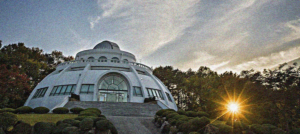

In [ ]:
from google.colab.patches import cv2_imshow

image = cv2.imread("/content/khuggle_test/0016.png") # 이미지 불러오기
cv2_imshow(image)

이미지 처리 및 로드 함수, 데이터 로더 클래스들을 정의합니다.

In [ ]:
# 불러오는 데이터가 이미지 파일 형식인지 확인합니다.
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])

# 본 베이스라인 코드에서는 이미지를 YCbCr 채널로 변경 후, Y채널만 초해상화합니다.
# 최신 방법들은 RGB 이미지를 그대로 사용하니, 해당 코드를 반드시 사용해야하는 것은 아닙니다.
def load_img(filepath):
    img = Image.open(filepath).convert('YCbCr')
    y, _, _ = img.split()
    return y

# 이미지 크롭 사이즈를 설정하는 함수입니다.
def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)

# LR 이미지를 만드는 함수입니다.
# 본 베이스라인 코드에서는 HR 이미지에 해당 함수를 적용해서 x4 스케일만큼 다운샘플링한 이미지를 LR로 정의합니다.
# 초기부터 x4 스케일로 다운샘플링된 이미지 데이터셋도 제공합니다. 이 경우, 해당 함수는 필수가 아닙니다.
def input_transform(crop_size, upscale_factor):
    return Compose([
        CenterCrop(crop_size),
        Resize(crop_size//upscale_factor, Image.BICUBIC),
        ToTensor()
    ])

# HR 이미지를 만드는 함수입니다. 
# LR 이미지와 똑같은 크롭 사이즈를 사용해 자르고, 그것을 타겟 이미지로 설정합니다.
def target_transform(crop_size):
     return Compose([
        CenterCrop(crop_size),
        ToTensor()
    ])
     
# 앞서 정의한 함수들을 이용해 데이터셋을 생성하는 클래스를 정의합니다.
class DatasetFromFolder(data.Dataset):
    def __init__(self, hr_dir, lr_dir, input_transform=None, target_transform=None):
        super(DatasetFromFolder, self).__init__()
        self.hr_filenames = [join(hr_dir, x) for x in listdir(hr_dir) if is_image_file(x)]
        self.lr_filenames = [join(lr_dir, x) for x in listdir(lr_dir) if is_image_file(x)]

        self.input_transform = input_transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        input = load_img(self.lr_filenames[index])
        target = load_img(self.hr_filenames[index])
        if self.input_transform:
            input = self.input_transform(input)
        if self.target_transform:
            target = self.target_transform(target)

        return input, target

    def __len__(self):
        return len(self.hr_filenames)

# 64의 크롭 사이즈를 갖고 훈련 데이터셋을 만드는 함수입니다.
def get_training_set(hr_dir, lr_dir, upscale_factor):
   
    crop_size = calculate_valid_crop_size(64, upscale_factor)

    return DatasetFromFolder(hr_dir, lr_dir,
                             input_transform=input_transform(crop_size, upscale_factor),
                             target_transform=target_transform(crop_size))

# 64의 크롭 사이즈를 갖고 검증 데이터셋을 만드는 함수입니다.
# 함수명은 테스트(추론) 데이터셋으로 보일 수 있으나, 검증 데이터셋의 경우에도 test_set 등으로 명시하는 것이 일반적입니다.
def get_test_set(hr_dir, lr_dir, upscale_factor):
   
    crop_size = calculate_valid_crop_size(64, upscale_factor)

    return DatasetFromFolder(hr_dir, lr_dir,
                             input_transform=input_transform(crop_size, upscale_factor),
                             target_transform=target_transform(crop_size))

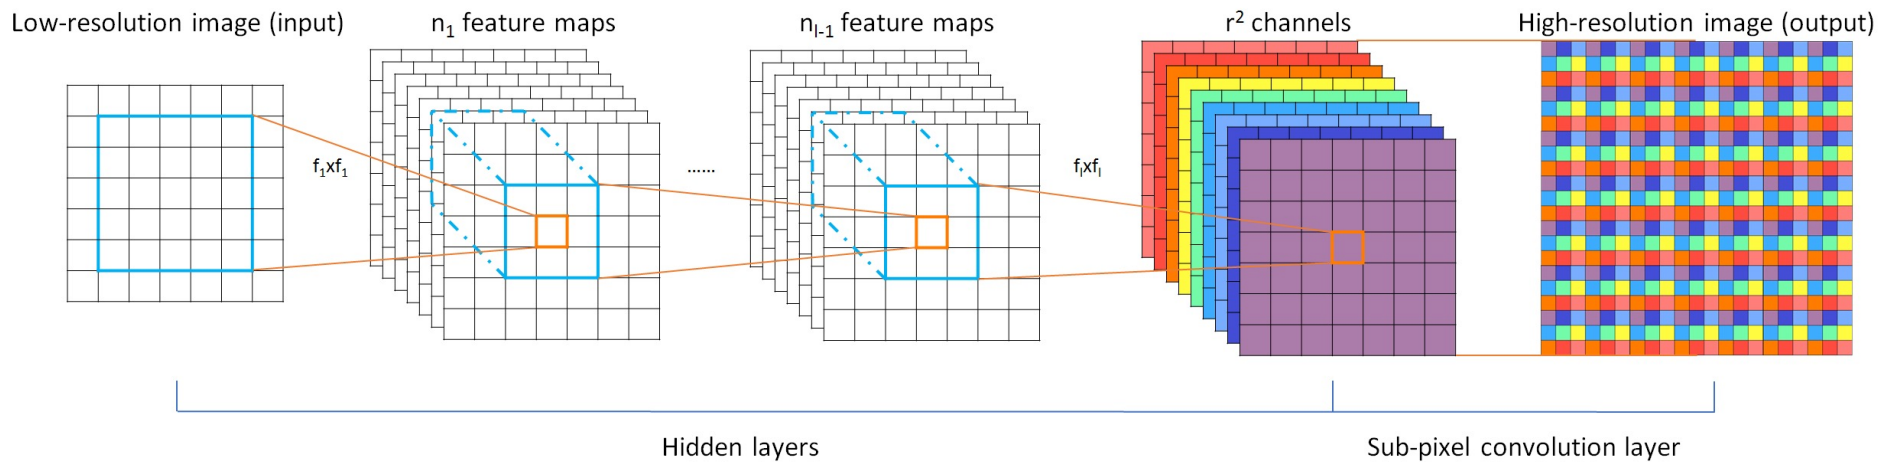

ESPCN (Efficient Sub-Pixel Convolutional Neural Network) 모델을 정의합니다. 

ESPCN은 2016년에 개발된 초해상화 전용 딥러닝 네트워크입니다.

자세한 내용은 [논문](https://arxiv.org/pdf/1609.05158v2.pdf)과 [블로그](https://mole-starseeker.tistory.com/m/84)를 참고하세요.

In [ ]:
# 본 베이스라인은 이미지를 YCbCr로 변환하고, Y채널만 뽑아서 초해상화합니다.
# 따라서 ESPCN의 __init__에 num_channels=1로 정의되어있습니다.
# 최신 모델들은 RGB 채널을 그대로 사용하는 경우가 많으니, 참고바랍니다.

class ESPCN(nn.Module):
    def __init__(self, scale_factor=4, num_channels=1):
        super(ESPCN, self).__init__()
        self.first_part = nn.Sequential(
            nn.Conv2d(num_channels, 64, kernel_size=5, padding=5//2),
            nn.Tanh(),
            nn.Conv2d(64, 32, kernel_size=3, padding=3//2),
            nn.Tanh(),
        )
        self.last_part = nn.Sequential(
            nn.Conv2d(32, num_channels * (scale_factor ** 2), kernel_size=3, padding=3 // 2),
            nn.PixelShuffle(scale_factor)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m.in_channels == 32:
                    nn.init.normal_(m.weight.data, mean=0.0, std=0.001)
                    nn.init.zeros_(m.bias.data)
                else:
                    nn.init.normal_(m.weight.data, mean=0.0, std=sqrt(2/(m.out_channels*m.weight.data[0][0].numel())))
                    nn.init.zeros_(m.bias.data)

    def forward(self, x):
        x = self.first_part(x)
        x = self.last_part(x)
        return x

모델 훈련 및 검증을 위한 부분입니다.

In [ ]:
print('''
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@   @@@@@   .@@.  #@@@@@@&   @@@*  *@@@@@@   &@@@@@@@       .@@@@@@@@        @@@@*  /@@@@@@@@         @@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@   @@@.   @@@@*  /@@@@@@@   @@@#  .@@@@@@   #@@@@    /@@@@% @@@@@    .@@@@@ .@@@#   @@@@@@@@   @@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@   @%   @@@@@@#   @@@@@@@   @@@@   @@@@@@/  ,@@&   @@@@@@@@@@@@@   &@@@@@@@@@@@@@   @@@@@@@@   &@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@      ,@@@@@@@@             @@@@   @@@@@@&   @@,  .@@@@      @@#   @@@@      /@@@   @@@@@@@@         @@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@   &@   .@@@@@@   @@@@@@@   &@@@   @@@@@@&   @@&   @@@@@@@   %@@   &@@@@@@#   @@@   @@@@@@@@(  .@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@,  *@@@   .@@@@   @@@@@@@.  (@@@@   #@@@&   #@@@@    @@@@@*  *@@@    %@@@@&   @@@   @@@@@@@@&   @@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@%   @@@@@    @@   &@@@@@@(  .@@@@@&       *@@@@@@@@(        *@@@@@@&         @@@@         *@@         @@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@          @@@@@&          @@@@@@@.         @@@@@@           @@@@@@@@@@@@@.  (@@@@@@@&   @@@@@@,  /@@@@@,        #@@*  ,@@@@   ,@@@   @@@@*  *@
@@@@@   ,@@@@@@@@@@@@   ,@@@@@@    @@@.   @@@@@@(   @@@@   @@@@@@    @@@@@@@@@@@(  .@@@@@@@@   @@@@@@#   @@@.   &@@@@@@@@@&   @@.   @@@@@,  &@@@%  ,@@
@@@   #@@@@@@@@@@@@.  ,@@@@@@@@,  .@&   @@@@@@@@@   @@@   @@@@@@@(   @@@@@@@@@@&   @@@@@@@@   @@@@@@&   @@#   @@@@@@@@@@@&      @@@@@@@@  @@@@@  .@@@@
@@   %@@@%      @@.   @@@@@@@@&   @@   @@@@@@@@@   @@@   @@@@@@@&   @@@@@@@@@@@   @@@@@@@@   @@@@@@@   @@(   @@@@@@@@@@@@      @@@@@@@@  (@@@@   @@@@@
@&   &@@@@@@   @@@   /@@@@@@@   /@@.   @@@@@@@/   @@@   %@@@@@@   *@@@@@@@@@@@   @@@@@@@@,  .@@@@@&   @@@    @@@@@@@@@@@   @@.   @@@@@@@@%@@@@#@@@@@@@
@@            @@@@%           &@@@@@           *@@@@*           @@@@@@@@@@@@@         &@@*          @@@@@%          @@@   @@@@.   &@@@   @@@@   &@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

''')

upscale_factor = 4   # 스케일을 정의합니다.
batchSize = 64       # 훈련 시의 배치 사이즈를 정의합니다.
testbatchSize = 1    # 테스트 시의 배치 사이즈를 정의합니다.
nEpochs = 2          # 에폭 수를 정의합니다.
lr = 1e-4            # 러닝 레이트를 정의합니다.
cuda = True          # GPU 사용 여부를 정의합니다.

seed = 81 # 시드를 정의합니다.
print("Seed: ", seed)
torch.manual_seed(seed)

if cuda and not torch.cuda.is_available():
    raise Exception("No GPU found, please run without cuda")

torch.manual_seed(seed)

device = torch.device("cuda" if cuda else "cpu") # GPU 사용 여부에 따라 cuda 또는 cpu로 연산 장치를 정의합니다.

print('===> Loading datasets')

# HR 이미지는 깨끗한 원본 이미지, LR 이미지는 화질 저하된 원본 이미지로 불러옵니다.
# 이때, 베이스라인 코드는 LR 이미지의 경우 x4로 줄어든 LR 이미지를 불러오는게 아니라, 원본 크기의 이미지로 불러온 후 bicubic interpolation을 이용해서 x4만큼 줄입니다.
# 초기에 x4로 줄어든 LR 이미지는 khuggle_train_degrade/khuggle_train_degraded_lr에서 찾아볼 수 있으니, 활용하셔도 됩니다.
train_set = get_training_set(hr_dir = '/content/khuggle_train_clean/khuggle_train_clean_hr', lr_dir = '/content/khuggle_train_degraded/khuggle_train_degraded_hr', upscale_factor=upscale_factor)

# 검증용 이미지의 경우에도 원본 이미지로 불러온 후 bicubic interpolation을 이용해서 x4만큼 줄입니다. 따라서 HR과 LR 경로가 같습니다.
# 검증용 이미지의 경우엔 초기에 x4로 줄어든 이미지가 제공되지 않습니다. 따라서 다른 검증용 데이터셋을 활용하셔도 됩니다.
test_set = get_test_set(hr_dir = '/content/khuggle_val', lr_dir = '/content/khuggle_val', upscale_factor=upscale_factor)

# 훈련용 & 검증용 데이터 로더를 정의합니다.
training_data_loader = DataLoader(dataset=train_set, num_workers=2, batch_size=batchSize, shuffle=True)
testing_data_loader = DataLoader(dataset=test_set, num_workers=2, batch_size=testbatchSize, shuffle=False)

# 정의된 ESPCN 모델을 연산 장치에 연결합니다.
print('===> Building model')
model = ESPCN().to(device)

# loss 함수를 L1 loss로 정의합니다.
criterion = nn.L1Loss()

# 옵티마이저를 Adam으로 정의합니다.
optimizer = optim.Adam(model.parameters(), lr=lr)

# 네트워크의 정보를 확인하는 함수를 정의합니다.
def print_network(net):
    num_params = 0
    for param in net.parameters():
        num_params += param.numel()
    
    print(net)
    print('Total number of parameters: %d' % num_params)

# 모델 훈련을 위한 함수입니다.
def train(epoch):
    epoch_loss = 0
    for iteration, batch in enumerate(training_data_loader, 1):
        input, target = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        prediction = model(input)
        loss = criterion(prediction, target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

        print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(training_data_loader), loss.item()))

    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(training_data_loader)))

# 모델 검증을 위한 함수입니다.
def test():
    avg_psnr = 0
    with torch.no_grad():
        for batch in testing_data_loader:
            input, target = batch[0].to(device), batch[1].to(device)

            prediction = model(input)
            mse = criterion(prediction, target)
            psnr = 10 *log10(1 / mse.item())
            avg_psnr += psnr

    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(testing_data_loader)))

# 모델 저장을 위한 함수입니다.
def checkpoint(epoch):
    model_out_path = "model_epoch_{}.pth".format(epoch)
    torch.save(model.state_dict(), model_out_path)
    print("Checkpoint saved to {}".format(model_out_path))

print("===> Training")
print_network(model)

for epoch in range(1, nEpochs + 1):
    train(epoch)
    test()
    checkpoint(epoch) 

이제 모델 추론(inference)을 합니다.

훈련된 모델을 불러와 손상된 경희대 이미지를 복원하고, 최종 제출용 .npy 파일을 생성합니다.

즉, khuggle_test에 있는 이미지들을 초해상화한 결과를 **1번부터 30번까지 순서대로 쌓아서 만든 .npy 파일이 최종 제출본**입니다.

따라서 해당 베이스라인을 사용하지 않더라도, 제출 형식은 맞춰주셔야 올바르게 점수 측정이 가능합니다.

In [ ]:
# 모델을 다시 한번 정의하고, 저장된 모델을 불러옵니다.
model = ESPCN()
model.load_state_dict(torch.load('model_epoch_1.pth'))

# 추론용 이미지(즉, 손상된 경희대 이미지)를 불러오고, 번호 순서대로 정렬합니다.
infer_dataset = '/content/khuggle_test'
infer_dataset_images = listdir(infer_dataset)
infer_dataset_images.sort()

np_list = []

for file in infer_dataset_images:

  print(file)

  # 이미지를 불러오고 YCbCr로 변환 후, Y채널만 따로 분리합니다.
  img = Image.open(infer_dataset+'/'+file).convert('YCbCr')
  y, cb, cr = img.split()
  
  # Y채널 이미지를 모델에 넣을 수 있는 형태(텐서)로 변환하고 인풋으로 정의합니다.
  img_to_tensor = ToTensor()
  input = img_to_tensor(y).view(1, -1, y.size[1], y.size[0])
  model = model.cuda()
  model = nn.DataParallel(model)
  input = input.cuda()
  
  # 인풋을 모델에 통과시켜 아웃풋을 얻습니다.
  out = model(input)

  # 이미지를 정규화하고 numpy array 형태로 변환합니다.
  out = out.cpu()
  out_img_y = out[0].detach().numpy()
  out_img_y *= 255.0
  out_img_y = out_img_y.clip(0, 255)
  out_img_y = Image.fromarray(np.uint8(out_img_y[0]), mode='L')

  # Y채널만 초해상화했기에, 나머지 Cb, Cr 채널도 초해상화해서 함께 합쳐줘야 합니다.
  # Cb, Cr 채널은 PIL.Image에서 제공하는 bicubic interpolation 메소드를 사용하여 초해상화 합니다.
  # 해당 방법은 RGB 채널을 그대로 초해상화하는 최신 모델의 경우엔 사용되지 않습니다.
  out_img_cb = cb.resize(out_img_y.size, Image.BICUBIC)
  out_img_cr = cr.resize(out_img_y.size, Image.BICUBIC)

  # Y, Cb, Cr 채널의 이미지를 하나로 합치고 RGB 채널로 변환합니다.
  out_img = Image.merge('YCbCr', [out_img_y, out_img_cb, out_img_cr]).convert('RGB')

  # 결과 이미지가 저장될 경로를 정의하고 생성합니다.
  output_path = '/content/output'
  if not os.path.exists(output_path):
    os.makedirs(output_path)

  # 저장된 이미지를 다시 numpy array 형태로 불러와 순서대로 쌓아서 하나의 리스트를 생성합니다.
  out_img.save(output_path+'/'+file)
  out_np = np.asarray(Image.open(output_path+'/'+file))
  np_list.append(out_np)

# numpy array로 구성된 리스트를 numpy array 형태로 변환합니다.
np_submission_array = np.array(np_list)

# 'submission.npy' 형태로 최종 제출 파일을 정의합니다.
np.save('/content/submission', np_submission_array)

print('Submission file is complete. Good luck!')